In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
# Import modules
from elastica.modules import BaseSystemCollection, Constraints, Forcing, Damping

# Import Cosserat Rod Class
from elastica.rod.cosserat_rod import CosseratRod

# Import Damping Class
from elastica.dissipation import AnalyticalLinearDamper

# Import Boundary Condition Classes
from elastica.boundary_conditions import OneEndFixedRod, FreeRod
from elastica.external_forces import EndpointForces 
from elastica.external_forces import GravityForces

# Import Timestepping Functions
from elastica.timestepper.symplectic_steppers import PositionVerlet 
from elastica.timestepper import extend_stepper_interface
from elastica.timestepper import integrate 

from analytical_result import analytical_result

In [103]:
%matplotlib inline
loops = 15
softer_angle = np.zeros(loops)
stiffer_angle = np.zeros(loops)
analytical_softer_angle = np.zeros(loops)
analytical_stiffer_angle = np.zeros(loops)
end_force_zs = np.concatenate((np.linspace(1e5,1.12e7,6,endpoint=False),np.linspace(1.12e7,1e8,loops-6)),axis=0)
for i in range(loops):
    class PendulumSimulator(BaseSystemCollection, Constraints, Forcing, Damping):
        pass 

    Pendulum_Sim = PendulumSimulator()

    # Create Rod 
    n_elem = 40
    #--------------mGS Unit-----------------
    # density = 1200* 1e-6 * 1000000 #mGS
    # gravitational_acc = -9.80665e0 * 1e3 /1000000 #mGS
    # base_length = 10 #mGS 
    # base_radius = 1 #mGS
    # E = 1.2e9
    #--------------CGS Unit------------------
    # density = 2273* 1e-3   #g/cm^3
    # gravitational_acc = -9.80665e0 * 1e2  #cm/s^2
    # base_length = 0.3 # cm
    # base_radius = 0.06 # cm
    # E = 1.4e6* 10 # g/(cm*s)
    #--------------SI Unit------------------
    # density = 1200  # kg/m^3
    # gravitational_acc = -9.80665e0   #m/s^2
    # base_length = 10e-3 # m
    # base_radius = 1e-3 # m
    # E = 1.2e9 # kg/(m*s)
    #--------------mmGS Unit------------------
    density = 2.273  # mg/mm^3
    gravitational_acc = -9.80665e3  #mm/s^2
    base_length = 3 #mm 
    base_radius = 0.3 #mm
    scale_E = 1e-5
    E = 1.4e9 * scale_E # mg/(mm*s^2)


    dl = base_length / n_elem 
    # dt = 0.002 * dl 
    dt = 1.0e-4
    nu = 5 #damping constant
    shear_modulus = E / (3.0)

    start = np.array([0.0,0.0,0.0])
    direction = np.array([0.0, 1.0, 0.0])
    normal = np.array([1.0, 0.0, 0.0])
    base_area = np.pi * base_radius**2
    # base_area = base_radius*np.sqrt(3)/3

    origin_force = np.array([0.0, 0.0, 0.0])
    end_force = np.array([0.0, 0.0, -end_force_zs[i]*scale_E])
    ramp_up_time = 0.15

    softer_rod = CosseratRod.straight_rod(
        n_elem,
        start,
        direction,
        normal,
        base_length,
        base_radius,
        density,
        youngs_modulus=E,
        shear_modulus = shear_modulus,
    )

    stiffer_rod = CosseratRod.straight_rod(
        n_elem,
        start,
        direction,
        normal,
        base_length,
        base_radius,
        density,
        youngs_modulus = E*10,
        shear_modulus = shear_modulus*10,
    )


    Pendulum_Sim.append(softer_rod)
    Pendulum_Sim.append(stiffer_rod)
    Pendulum_Sim.dampen(softer_rod).using(
        AnalyticalLinearDamper,
        damping_constant = nu,
        time_step = dt,
    )
    Pendulum_Sim.dampen(stiffer_rod).using(
        AnalyticalLinearDamper,
        damping_constant = nu,
        time_step = dt,
    )

    Pendulum_Sim.constrain(softer_rod).using(
        OneEndFixedRod,constrained_position_idx = (0,), constrained_director_idx= (0,)
    )
    Pendulum_Sim.constrain(stiffer_rod).using(
        OneEndFixedRod,constrained_position_idx = (0,), constrained_director_idx= (0,)
    )
    print("One end of the rod is now fixed in place")

    # Pendulum_Sim.add_forcing_to(softer_rod).using(
    #     GravityForces, acc_gravity = np.array([0.0,0.0,gravitational_acc]) 
    # )
    # Pendulum_Sim.add_forcing_to(stiffer_rod).using(
    #     GravityForces, acc_gravity = np.array([0.0,0.0,gravitational_acc]) 
    # )

    Pendulum_Sim.add_forcing_to(softer_rod).using(
        EndpointForces, origin_force, end_force, ramp_up_time = ramp_up_time
    )
    Pendulum_Sim.add_forcing_to(stiffer_rod).using(
        EndpointForces, origin_force, end_force, ramp_up_time=ramp_up_time
    )
    print("Forces added to the rod")

    Pendulum_Sim.finalize()
    print("System finalized")

    #----------------------------time integration----------------------------------
    final_time = 15
    total_steps = int(final_time / dt)
    timestepper = PositionVerlet()
    integrate(timestepper, Pendulum_Sim, final_time, total_steps)

    softer_angle[i] = np.arctan(-softer_rod.position_collection[2,-1] / softer_rod.position_collection[1,-1]) / (2*np.pi) * 360
    stiffer_angle[i] = np.arctan(-stiffer_rod.position_collection[2,-1] / stiffer_rod.position_collection[1,-1]) / (2*np.pi) * 360

    analytical_softer_position = analytical_result(softer_rod, end_force, shearing=False, n_elem=500)
    analytical_stiffer_position = analytical_result(stiffer_rod, end_force, shearing=False, n_elem=500)
    analytical_softer_angle[i] = np.arctan(-analytical_softer_position[1][-1]/analytical_softer_position[0][-1])/ (2*np.pi) * 360
    analytical_stiffer_angle[i] = np.arctan(-analytical_stiffer_position[1][-1]/analytical_stiffer_position[0][-1]) / (2*np.pi) * 360

One end of the rod is now fixed in place
Forces added to the rod
System finalized


  0%|          | 0/150000 [00:00<?, ?it/s]

100%|██████████| 150000/150000 [00:19<00:00, 7820.46it/s]


Final time of simulation is :  14.999999999971712
One end of the rod is now fixed in place
Forces added to the rod
System finalized


100%|██████████| 150000/150000 [00:19<00:00, 7849.25it/s]


Final time of simulation is :  14.999999999971712
One end of the rod is now fixed in place
Forces added to the rod
System finalized


100%|██████████| 150000/150000 [00:19<00:00, 7756.25it/s]


Final time of simulation is :  14.999999999971712
One end of the rod is now fixed in place
Forces added to the rod
System finalized


100%|██████████| 150000/150000 [00:19<00:00, 7793.30it/s]


Final time of simulation is :  14.999999999971712
One end of the rod is now fixed in place
Forces added to the rod
System finalized


100%|██████████| 150000/150000 [00:19<00:00, 7829.03it/s]


Final time of simulation is :  14.999999999971712
One end of the rod is now fixed in place
Forces added to the rod
System finalized


100%|██████████| 150000/150000 [00:19<00:00, 7843.79it/s]


Final time of simulation is :  14.999999999971712
One end of the rod is now fixed in place
Forces added to the rod
System finalized


100%|██████████| 150000/150000 [00:19<00:00, 7820.09it/s]


Final time of simulation is :  14.999999999971712
One end of the rod is now fixed in place
Forces added to the rod
System finalized


100%|██████████| 150000/150000 [00:19<00:00, 7838.34it/s]


Final time of simulation is :  14.999999999971712
One end of the rod is now fixed in place
Forces added to the rod
System finalized


100%|██████████| 150000/150000 [00:19<00:00, 7870.81it/s]


Final time of simulation is :  14.999999999971712
One end of the rod is now fixed in place
Forces added to the rod
System finalized


100%|██████████| 150000/150000 [00:19<00:00, 7536.42it/s]


Final time of simulation is :  14.999999999971712
One end of the rod is now fixed in place
Forces added to the rod
System finalized


100%|██████████| 150000/150000 [00:19<00:00, 7849.41it/s]


Final time of simulation is :  14.999999999971712
One end of the rod is now fixed in place
Forces added to the rod
System finalized


100%|██████████| 150000/150000 [00:19<00:00, 7878.29it/s]


Final time of simulation is :  14.999999999971712
One end of the rod is now fixed in place
Forces added to the rod
System finalized


100%|██████████| 150000/150000 [00:19<00:00, 7870.07it/s]


Final time of simulation is :  14.999999999971712
One end of the rod is now fixed in place
Forces added to the rod
System finalized


100%|██████████| 150000/150000 [00:18<00:00, 7895.50it/s]


Final time of simulation is :  14.999999999971712
One end of the rod is now fixed in place
Forces added to the rod
System finalized


100%|██████████| 150000/150000 [00:19<00:00, 7853.33it/s]

Final time of simulation is :  14.999999999971712


In [104]:
print(analytical_stiffer_angle, stiffer_angle)

[ 0.192992    3.75796019  7.29406249 10.77523391 14.17781208 17.48137947
 20.66929238 36.91182298 48.36726401 56.29087556 61.89966692 66.00623927
 69.11342168 71.53331845 73.46487224] [ 0.19031742  3.69972676  7.14870907 10.4871622  13.6767675  16.69260603
 19.52218174 32.81281375 41.49407091 47.52002059 51.96516944 55.40234868
 58.15691099 60.42632454 62.33740257]


In [105]:
print(analytical_softer_angle,softer_angle)

[ 1.92919792 33.29810682 52.00075205 62.28021901 68.40432592 72.38435437
 75.15392482 82.41678829 84.92053482 86.18318408 86.94355003 87.45145722
 87.81468498 88.08732498 88.29949948] [ 1.9016316  29.9931614  44.23626613 52.27588977 57.51407102 61.25617672
 64.09825266 73.24453967 77.57823925 80.32005059 82.30405474 83.85393893
 85.12421827 86.19785042 87.1213405 ]


In [106]:
print(np.linspace(1e5,1.12e7,5,endpoint=False), np.linspace(1.12e7,1e8,9))
print(np.linspace(1e5,1e8,10))

[ 100000. 2320000. 4540000. 6760000. 8980000.] [1.12e+07 2.23e+07 3.34e+07 4.45e+07 5.56e+07 6.67e+07 7.78e+07 8.89e+07
 1.00e+08]
[1.00e+05 1.12e+07 2.23e+07 3.34e+07 4.45e+07 5.56e+07 6.67e+07 7.78e+07
 8.89e+07 1.00e+08]


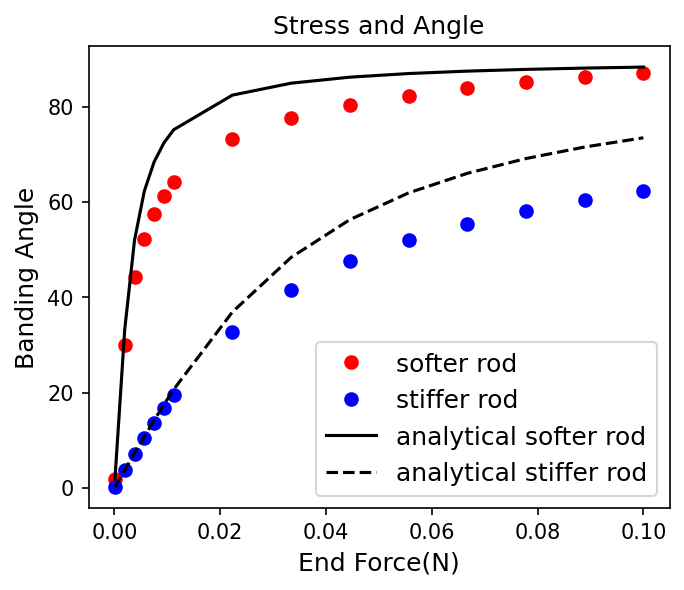

In [107]:
%matplotlib inline
# update the plot every 0.1 second
fig = plt.figure(figsize=(5,4), frameon=True, dpi=150)
ax = fig.add_subplot(111)
ax.plot(
    end_force_zs*1e-9,
    softer_angle,
    "ro",
    label = "softer rod"
)
ax.plot(
    end_force_zs*1e-9,
    stiffer_angle,
    "bo",
    label = "stiffer rod"
)
ax.plot(
    end_force_zs*1e-9,
    analytical_softer_angle,
    "k-",
    label = "analytical softer rod"
)
ax.plot(
    end_force_zs*1e-9,
    analytical_stiffer_angle,
    "k--",
    label = "analytical stiffer rod"
)
ax.legend(prop={"size":12}, loc="lower right")
ax.set_ylabel("Banding Angle", fontsize=12)
ax.set_xlabel("End Force(N)", fontsize=12)
ax.set_title("Stress and Angle")
plt.savefig('Stress_Angle.jpg')
plt.show()
plt.close()